<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction:-Unsupervised-learning-of-filters" data-toc-modified-id="Introduction:-Unsupervised-learning-of-filters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction: Unsupervised learning of filters</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Prepare-an-image-provider-class" data-toc-modified-id="Prepare-an-image-provider-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare an image provider class</a></span></li><li><span><a href="#Define-a-set-of-receptive-fields" data-toc-modified-id="Define-a-set-of-receptive-fields-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define a set of receptive fields</a></span></li><li><span><a href="#Definition-of-a-Self-Organizing-Map-(SOM)-class" data-toc-modified-id="Definition-of-a-Self-Organizing-Map-(SOM)-class-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Definition of a Self Organizing Map (SOM) class</a></span></li><li><span><a href="#Testing-the-SOM-class-with-a-toy-world-problem" data-toc-modified-id="Testing-the-SOM-class-with-a-toy-world-problem-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Testing the SOM class with a toy-world problem</a></span></li><li><span><a href="#Training-of-a-SOM-with-image-patches-as-input" data-toc-modified-id="Training-of-a-SOM-with-image-patches-as-input-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training of a SOM with image patches as input</a></span></li></ul></div>

# Introduction: Unsupervised learning of filters

In this notebook we will try to learn a "good" set of filters. However, in contrast to CNNs we will do this in an unsupervised fashion. With a "good" set we will mean, that the filter responses are a helpful input for a classifier that has to learn to classify the images just based on the filter response values.

# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2

print( "Your NumPy version is: " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is: " + keras.__version__ )
print( "Your OpenCV version is: " + cv2.__version__ )

Using TensorFlow backend.


Your NumPy version is: 1.13.3
Your TensorFlow version is: 1.5.1
Your Keras version is: 2.2.3
Your OpenCV version is: 3.4.1


# Prepare an image provider class

In [2]:
import os
from os import listdir
from os.path import isdir, isfile, join
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_images = []
       
        class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder", root_folder, "I found the following subfolders/classes:")
        print(class_names)
        
        for class_name in class_names:
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name) if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames), subfolder_name) )
            
            for filename in filenames:
                
                self.all_images.append( [filename, class_name] )              
        
        self.nr_images = len(self.all_images)
        print("There are {} images in total available.".format(self.nr_images))
     
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image * (1.0 / 255.0)
        return image
        
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        
        image_filename  = self.all_images[rnd_idx][0]
        image_classname = self.all_images[rnd_idx][1]
        
        image = self.load_image(image_filename)
        
        return image, image_classname
        
        
        
    

Let's test the image provider class:

In [3]:
my_image_provider = image_provider( "data" )

Under folder data I found the following subfolders/classes:
['bikes', 'cars']
1344 files in subfolder data/bikes/
1307 files in subfolder data/cars/
There are 2651 images in total available.


Let us retrieve randomly one of the images and display it.

image has type <class 'numpy.ndarray'>
image has shape (379, 500, 3)


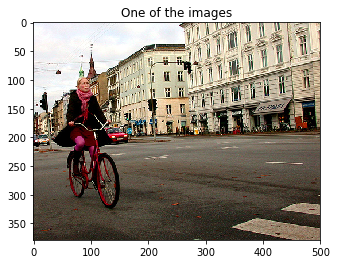

In [4]:
import matplotlib.pyplot as plt

image, label = my_image_provider.get_random_image()
print("image has type", type(image))
print("image has shape", image.shape)
plt.imshow(image)
plt.title("One of the images")
plt.show()

# Define a set of receptive fields

In [5]:
RF_SIZE = 40

class receptive_fields_regular:
    
    #
    # Given some image shape
    # create receptive fields
    # on a regular grid
    # with no overlap
    #
    def __init__(self, image_shape):
        
        img_dimx = image_shape[1]
        img_dimy = image_shape[0]
        
        self.all_fields = []
                
        x = 0
        y = 0
        
        while y+RF_SIZE < img_dimy:
             
            while x+RF_SIZE < img_dimx:
            
                next_field = ( x, y, RF_SIZE )
                self.all_fields.append( next_field )                
                x += RF_SIZE
                
            x = 0
            y += RF_SIZE
            
        self.nr_fields = len(self.all_fields)
            
        #print("I generated {} receptive fields.".
        #      format(self.nr_fields))
    
    #
    # Given the pre-computed set of receptive fields,
    # draw their positions into the specified image
    # by visualizing each receptive field with a rectangle
    #
    def show_fields(self, image):
        
        cpy_image = image.copy()
        
        for field in self.all_fields:
            
            x = field[0]
            y = field[1]
            size = field[2]
            
            cv2.rectangle(cpy_image, (x,y), (x+size,y+size), (1,1,1), 2)
            
        plt.imshow(cpy_image)
        plt.title("Image with receptive field")
        plt.show()
        
        
        
    #
    # Given an image and a specific number of a receptive
    # field, return the corresponding image patch
    #
    def get_single_image_patch(self, image, field_nr):
        
        field = self.all_fields[field_nr]
        
        x = field[0]
        y = field[1]
        size = field[2]
        
        img_patch = image[ y:y+size, x:x+size ]
        return img_patch
        
     
    #
    # Given an image and the pre-computed set of receptive
    # fields, extract for each receptive field the current
    # corresponding image patch,
    # put it into a list of image patches,
    # then return the list
    #
    def get_all_image_patches(self, image):
        
        all_image_patches = []
        
        for field_nr, field in enumerate(self.all_fields):
            
            img_patch = self.get_single_image_patch(image, field_nr)
            
            all_image_patches.append( img_patch )
            
        return all_image_patches
            
            

Let's show the receptive fields:

label =  bikes


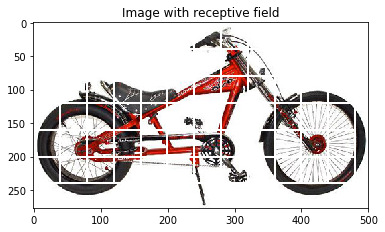

In [6]:
image, label = my_image_provider.get_random_image()
print("label = ", label)
my_receptive_fields = receptive_fields_regular(image.shape)
my_receptive_fields.show_fields( image )

Later, we need to extract the image patches from the original image:

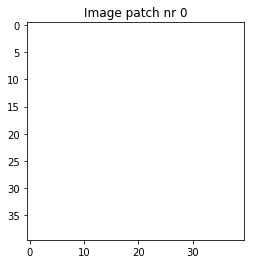

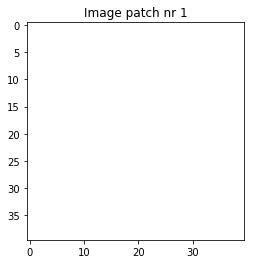

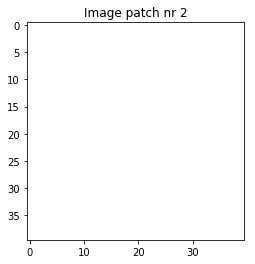

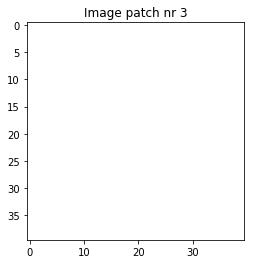

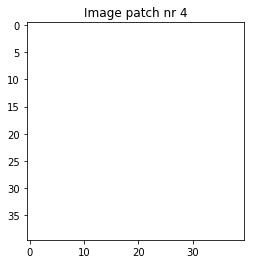

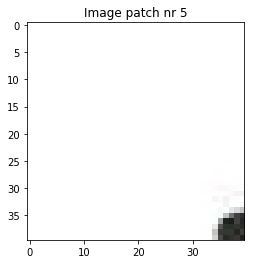

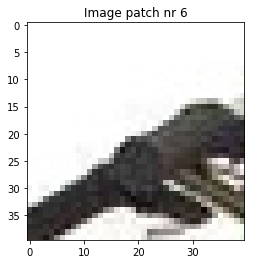

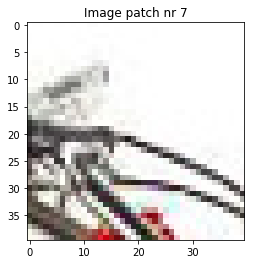

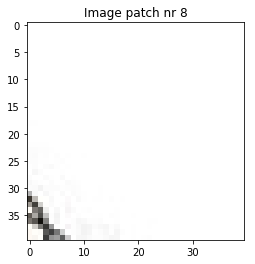

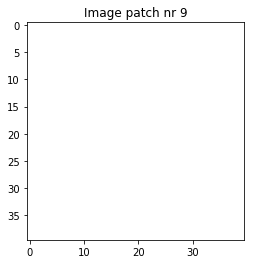

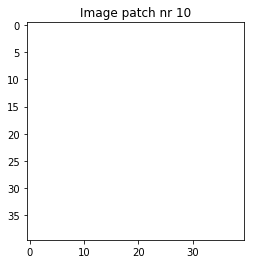

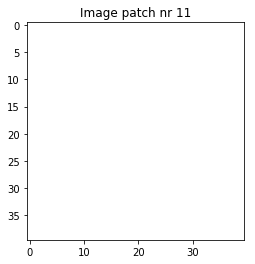

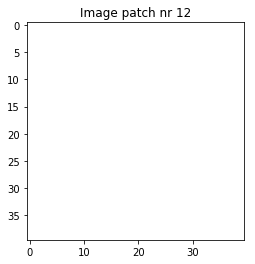

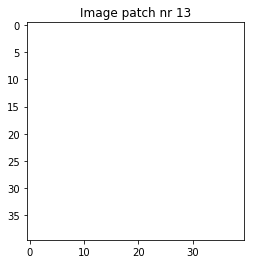

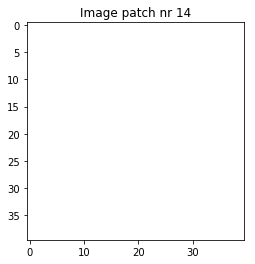

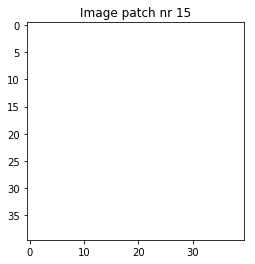

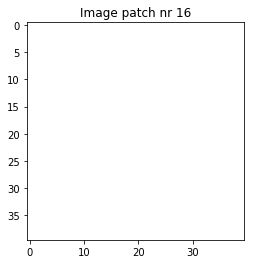

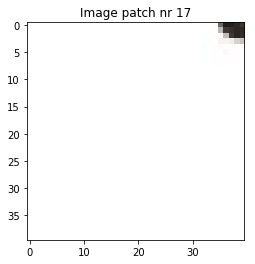

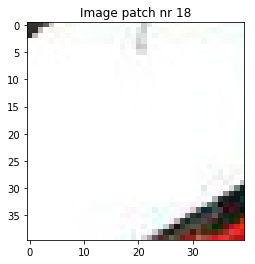

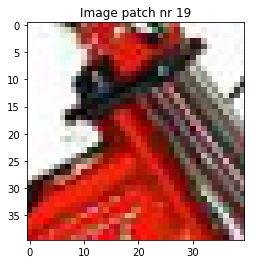

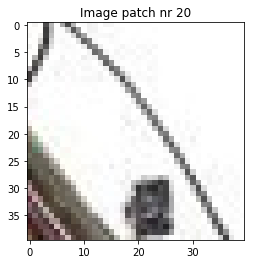

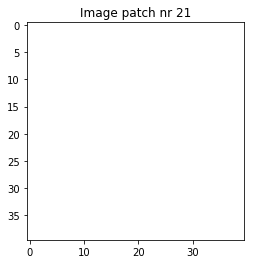

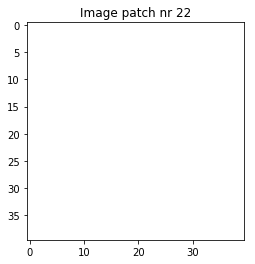

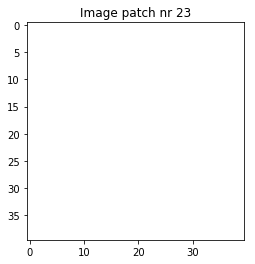

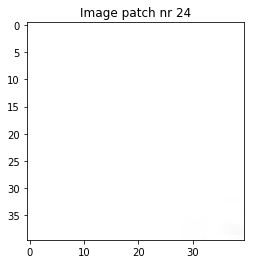

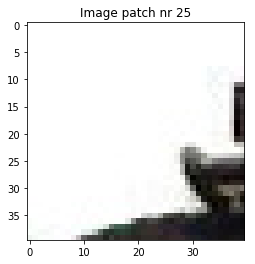

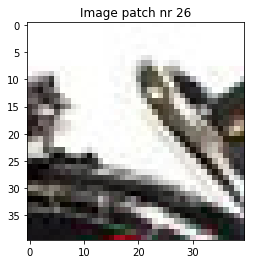

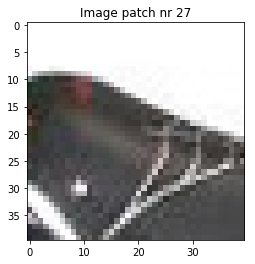

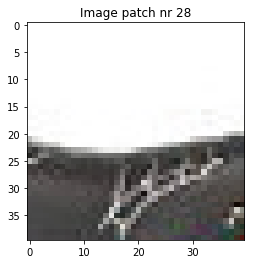

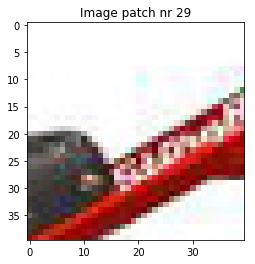

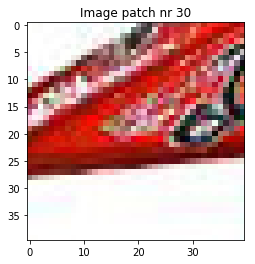

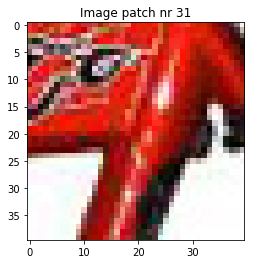

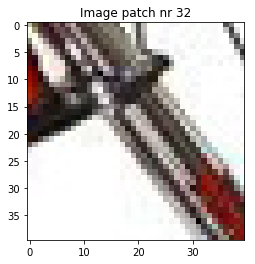

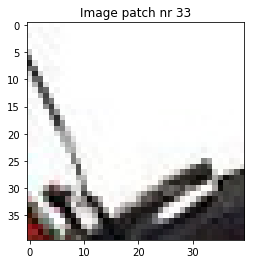

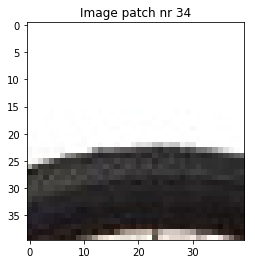

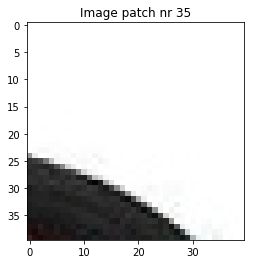

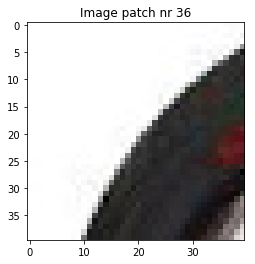

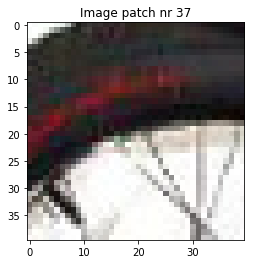

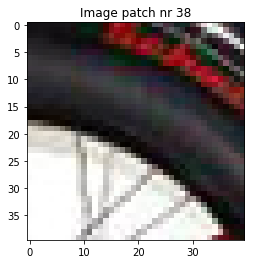

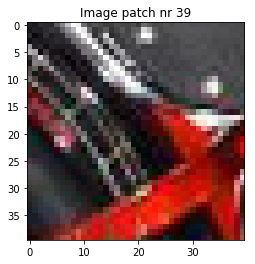

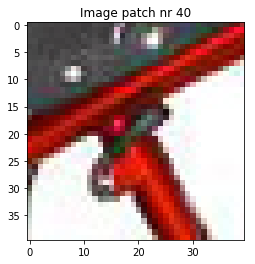

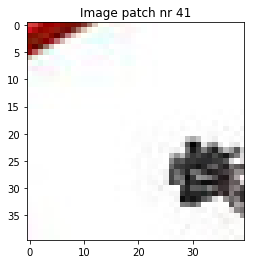

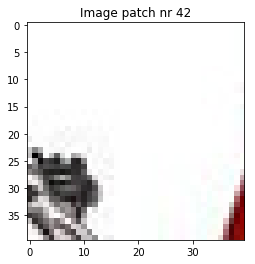

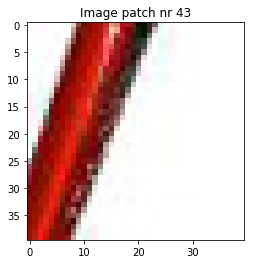

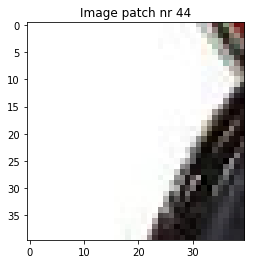

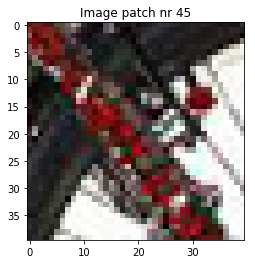

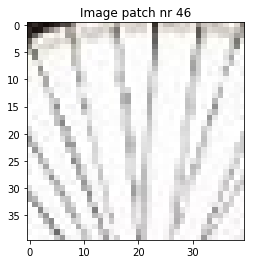

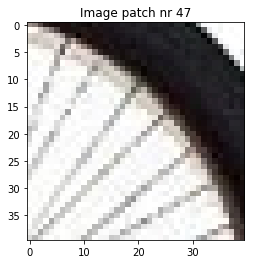

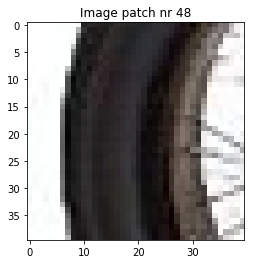

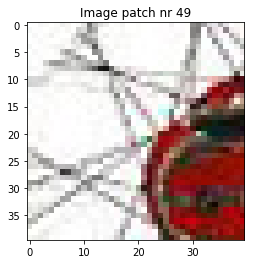

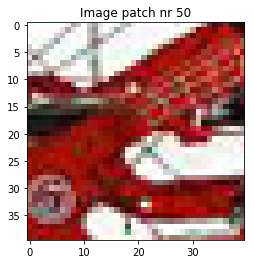

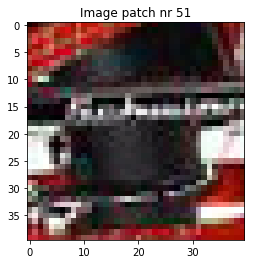

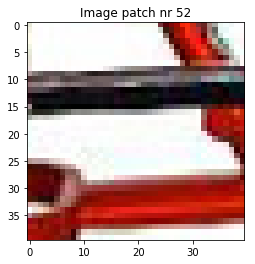

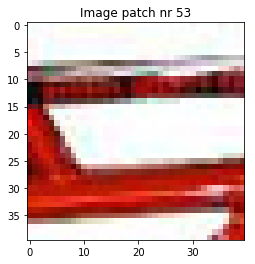

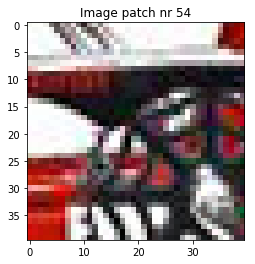

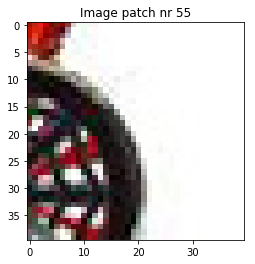

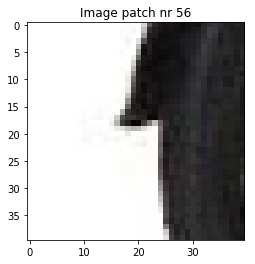

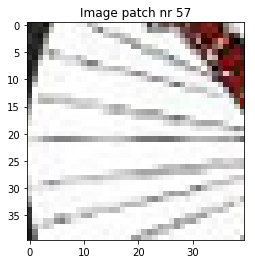

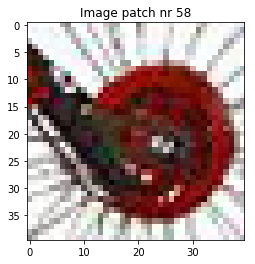

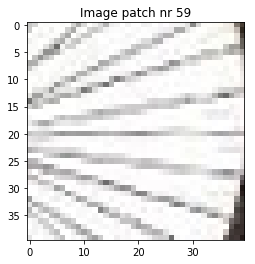

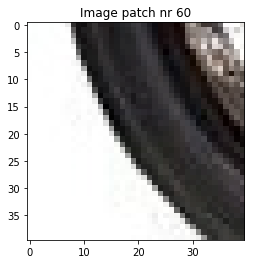

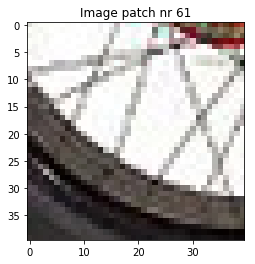

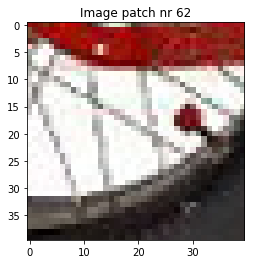

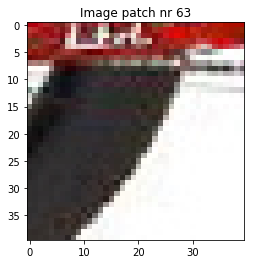

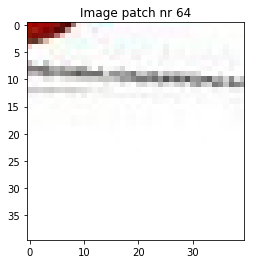

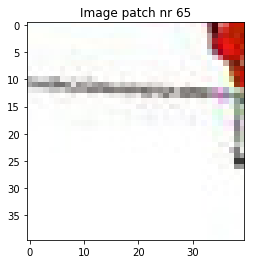

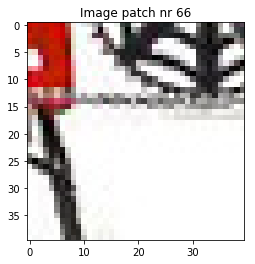

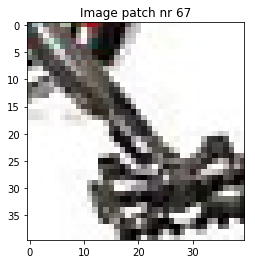

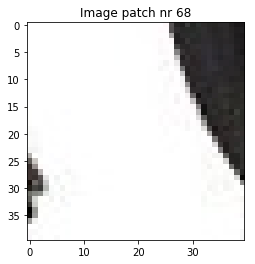

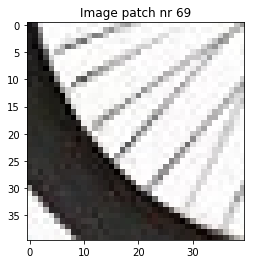

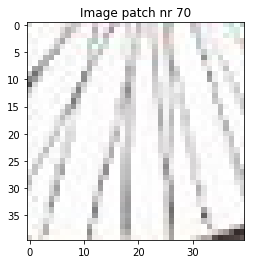

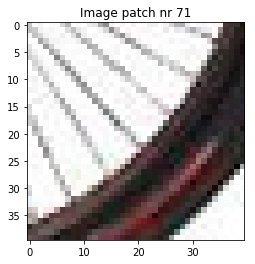

In [7]:
all_img_patches = my_receptive_fields.get_all_image_patches( image )
for img_patch_nr, img_patch in enumerate(all_img_patches):
    plt.imshow(img_patch)
    plt.title( "Image patch nr {}".format(img_patch_nr) )
    plt.show()

# Definition of a Self Organizing Map (SOM) class

In [28]:
class som_neuron:

    def __init__(self, nr_weights):

        self.weight_vec = np.zeros(nr_weights)
        self.output = 0


    def compute_output(self, input_vec):

        # this will compute the Euclidean distance between
        # the weight vector and the input vector
        #print("weight_vec has shape", self.weight_vec.shape)
        #print("input_vec has shape", input_vec.shape)
        self.output = np.linalg.norm(self.weight_vec-input_vec)


    #
    # This will adapt the neuron's weight vector
    # 'a little bit' into the direction of the
    # specified <adapt_vec>.
    #
    def adapt_to_vector(self, adapt_vec, learn_rate):

        delta_w = learn_rate * (adapt_vec - self.weight_vec)
        self.weight_vec += delta_w
        

class som:

    list_neurons = []
    nr_neurons = 0
    nr_steps_trained = 0

    #
    # Create a new Self-Organizing Map
    # with the desired number of neurons.
    #
    # Each neuron will store input_dim many
    # weights.
    def __init__(self, input_dim, nr_neurons):
        
        print("Generating a SOM with {} "
              "neurons that accept input vectors "
              "of dimension {}."
              .format(nr_neurons,input_dim))

        # 1. Store number of neurons
        self.nr_neurons = nr_neurons

        # 2. Create the desired number of neurons
        for i in range(nr_neurons):

            # "neurogenesis": create a new neuron
            neuron = som_neuron(input_dim)

            # store the new neuron in a list
            self.list_neurons.append( neuron )

        # 3. Prepare matrix for 2D neighborhood
        #    topology
        S = int(np.sqrt(nr_neurons))
        self.neighborhood = \
            np.arange(nr_neurons).reshape(S,S)
        print("Neuron neighborhood:\n", self.neighborhood)
        
        # 4. SOM has to yet be trained
        self.nr_steps_trained = 0
        
        # 5. Invalid so far are the following members:
        self.BMU_idx = -1



    #
    # Returns all the neighbors of a given neuron
    # Example:
    # 2D Neuron neighborhood of 49 neurons arranged in a 7x7 grid:
    #     [[ 0  1  2  3  4  5  6]
    #      [ 7  8  9 10 11 12 13]
    #      [14 15 16 17 18 19 20]
    #      [21 22 23 24 25 26 27]
    #      [28 29 30 31 32 33 34]
    #      [35 36 37 38 39 40 41]
    #      [42 43 44 45 46 47 48]]
    #
    def get_neighbors(self, id):

        N = self.nr_neurons
        S = int(np.sqrt(N))

        '''
        # Try out: 1D topology
        if id==0:
            return [1,N-1]
        if id==N-1:
            return [N-2,0]
        return [id-1,id+1]
        '''

        # case #1: corner?

        # top left corner
        if id==0:
            return [1,S]

        # top right corner
        if id==S-1:
            return [S-2,2*S-1]

        # bottom left corner:
        if id==N-S:
            return [N-S-S, N-S+1]

        # bottom right corner:
        if id==N-1:
            return [N-1-S, N-1-1]


        # case #2: border?
        y = int(id / S)
        x = id % S

        # top border
        if (y==0):
            return [id-1,id+1,id+S]

        # bottom border
        if (y==S-1):
            return [id-1,id+1,id-S]

        # left border
        if (x==0):
            return [id-S,id+S,id+1]

        # right border
        if (x==S-1):
            return [id-S,id+S,id-1]


        # case #3: normal cell?
        return [id-S,id-1,id+1,id+S]



    #
    # Compute neuron outputs for all SOM neurons
    # given an input vector and determine the
    # Best Matching Unit (BMU)    
    #
    def compute_outputs(self, input_vec):

        self.nr_steps_trained += 1
        
        # 1. Let all neurons comput their output values
        for neuron_nr in range(self.nr_neurons):

            # get the next neuron
            neuron = self.list_neurons[neuron_nr]

            # compute new output value of neuron
            neuron.compute_output(input_vec)


        # 2. Now determine the Best Matching Unit (BMU),
        #    i.e., the neuron with the SMALLEST output value
        self.BMU_idx = 0
        best_output_found = self.list_neurons[0].output
        for neuron_nr in range(1,self.nr_neurons):

            if (self.list_neurons[neuron_nr].output < best_output_found):
                best_output_found = self.list_neurons[neuron_nr].output
                self.BMU_idx = neuron_nr


    #
    # Given the computed outputs of all SOM neurons
    # and the BMU index,
    # adapt the BMU and its neighbored neurons
    # into the direction of the input vector      
    #                
    def adapt(self, input_vec, learn_rate):        
            
        # 1. Move the BMU a little bit into the direction
        #    of the input vector        
        BMU_neuron = self.list_neurons[self.BMU_idx]
        BMU_neuron.adapt_to_vector(input_vec, learn_rate)


        # 2. Now get the list of all neighbors of the BMU
        #    and move the neighbors a little bit into the
        #    direction of the input vector as well
        neighbors = self.get_neighbors(self.BMU_idx)

        # for all neighbors of this neuron:
        for j in neighbors:

            # get that neuron
            neighbored_neuron = self.list_neurons[j]

            # adapt the neighbored neuron to input vector
            # as well
            neighbored_neuron.adapt_to_vector(input_vec, learn_rate/2.0)

# Testing the SOM class with a toy-world problem

First, let us generate some 2D data:

(1000, 2)
(1000, 2)
(2000, 2)


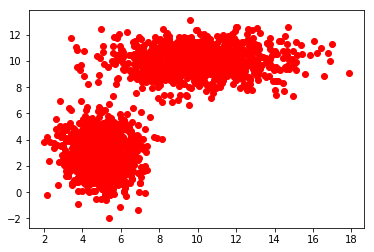

In [21]:
mean1 = (5, 3)
cov1 = [[1, 0], [0, 2]]
x1 = np.random.multivariate_normal(mean1, cov1, 1000)
print(x1.shape)

mean2= (10, 10)
cov2 = [[5, 0], [0, 1]]
x2 = np.random.multivariate_normal(mean2, cov2, 1000)
print(x2.shape)

x = np.vstack([x1, x2])
print(x.shape)

plt.plot(x[:,0], x[:,1], 'ro')
plt.show()

Now let us generate a SOM:

In [22]:
nr_dims = 2
nr_neurons = 49
my_som = som(nr_dims, nr_neurons)

Generating a SOM with 49 neurons that accept input vectors of dimension 2.
Neuron neighborhood:
 [[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]
 [35 36 37 38 39 40 41]
 [42 43 44 45 46 47 48]]


Next we train the SOM with the data:

In [23]:
NR_STEPS_TO_TRAIN = 10000
LEARN_RATE = 0.05
for train_step in range(0, NR_STEPS_TO_TRAIN):
    rnd_sample_idx = np.random.randint(0, x.shape[0])
    rnd_sample = x[rnd_sample_idx,:]
    my_som.compute_outputs( rnd_sample )
    my_som.adapt( rnd_sample, LEARN_RATE)

Now we plot the weight vectors of the SOM neurons:

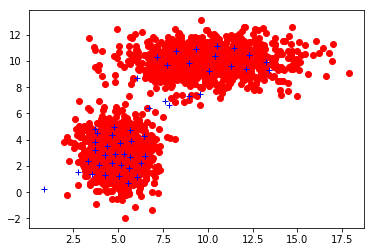

In [24]:
W = np.zeros((nr_neurons, nr_dims))
for neuron_idx in range(0, nr_neurons):
    next_neuron = my_som.list_neurons[neuron_idx]
    W[neuron_idx,:] = next_neuron.weight_vec
#print(W)
plt.plot(x[:,0], x[:,1], 'ro')
plt.plot(W[:,0], W[:,1], 'b+')
plt.show()


# Training of a SOM with image patches as input

In [31]:
nr_color_channels = 3
nr_input_vec_dims = RF_SIZE * RF_SIZE * nr_color_channels
nr_neurons = 49
my_som = som(nr_input_vec_dims, nr_neurons)

SOM_LEARN_RATE = 0.05

NR_STEPS_TO_TRAIN = 100

nr_image_patches_trained = 0

for train_step in range(0,NR_STEPS_TO_TRAIN):

    # 1. Get a random image from the image provider
    image, label = my_image_provider.get_random_image()
    
    # 2. Prepare a receptive field    
    my_receptive_fields = receptive_fields_regular(image.shape)
        
    # 3. Get all image patches from that receptive field
    #    for the current image
    all_img_patches = my_receptive_fields.get_all_image_patches( image )
    
    # 4. Go through all the extracted image patches
    for img_patch_nr, img_patch in enumerate(all_img_patches):
        
        # 4.1 The image patch is 3-dimensional:
        #     width x height x nr-channels
        #     However, as input for the SOM we need a 1D vector
        input_vec = img_patch.reshape(-1)
        
        # 4.2 Train the SOM with that input vector
        my_som.compute_outputs( input_vec )
        my_som.adapt( input_vec, SOM_LEARN_RATE )
        
        # 4.3 We have trained the SOM on one more image patch
        nr_image_patches_trained +=1
        
    # end-for (img_patch)
    
# end-for (SOM train_step)

print("The SOM was trained on {} image patches.".
      format(nr_image_patches_trained))


Generating a SOM with 49 neurons that accept input vectors of dimension 4800.
Neuron neighborhood:
 [[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]
 [35 36 37 38 39 40 41]
 [42 43 44 45 46 47 48]]
The SOM was trained on 13751 image patches.
